In [1]:
!unzip -qq DCdataset.zip

In [52]:
import os, shutil, pathlib

original_dir = pathlib.Path("./DCdataset/train/")
new_base_dir = pathlib.Path("./cats_vs_dogs_5000")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=4000)
make_subset("validation", start_index=4000, end_index=4500)
make_subset("test", start_index=4500, end_index=5000)

In [53]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [54]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_574 (Conv2D)         (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_575 (Conv2D)         (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                      

In [55]:
model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [56]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 8000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [57]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [58]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [59]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [60]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [61]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [62]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
250/250 [==============================] - 16s 55ms/step - loss: 0.6906 - accuracy: 0.5228 - val_loss: 0.6779 - val_accuracy: 0.5950
Epoch 2/30
250/250 [==============================] - 14s 54ms/step - loss: 0.6503 - accuracy: 0.6118 - val_loss: 0.6253 - val_accuracy: 0.6500
Epoch 3/30
250/250 [==============================] - 14s 54ms/step - loss: 0.6009 - accuracy: 0.6795 - val_loss: 0.5795 - val_accuracy: 0.6980
Epoch 4/30
250/250 [==============================] - 14s 53ms/step - loss: 0.5383 - accuracy: 0.7320 - val_loss: 0.5064 - val_accuracy: 0.7550
Epoch 5/30
250/250 [==============================] - 14s 54ms/step - loss: 0.4619 - accuracy: 0.7825 - val_loss: 0.4125 - val_accuracy: 0.8180
Epoch 6/30
250/250 [==============================] - 14s 54ms/step - loss: 0.3860 - accuracy: 0.8276 - val_loss: 0.3514 - val_accuracy: 0.8440
Epoch 7/30
250/250 [==============================] - 14s 55ms/step - loss: 0.3232 - accuracy: 0.8575 - val_loss: 0.3359 - val_accuracy:

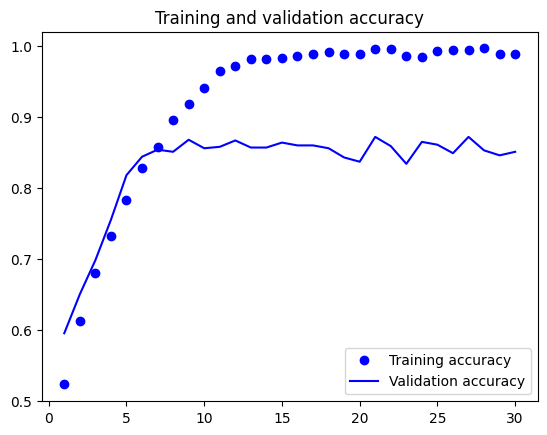

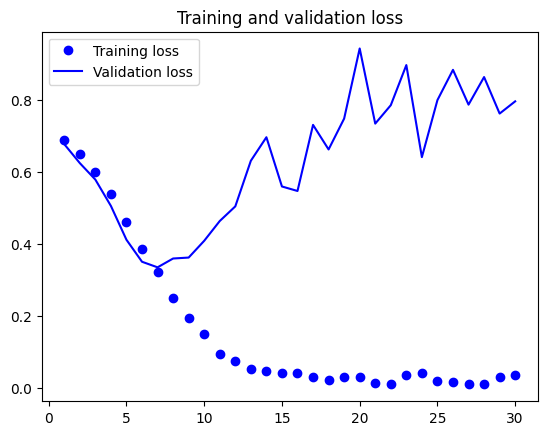

In [63]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [64]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 29ms/step - loss: 0.3691 - accuracy: 0.8380
Test accuracy: 0.838


In [65]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

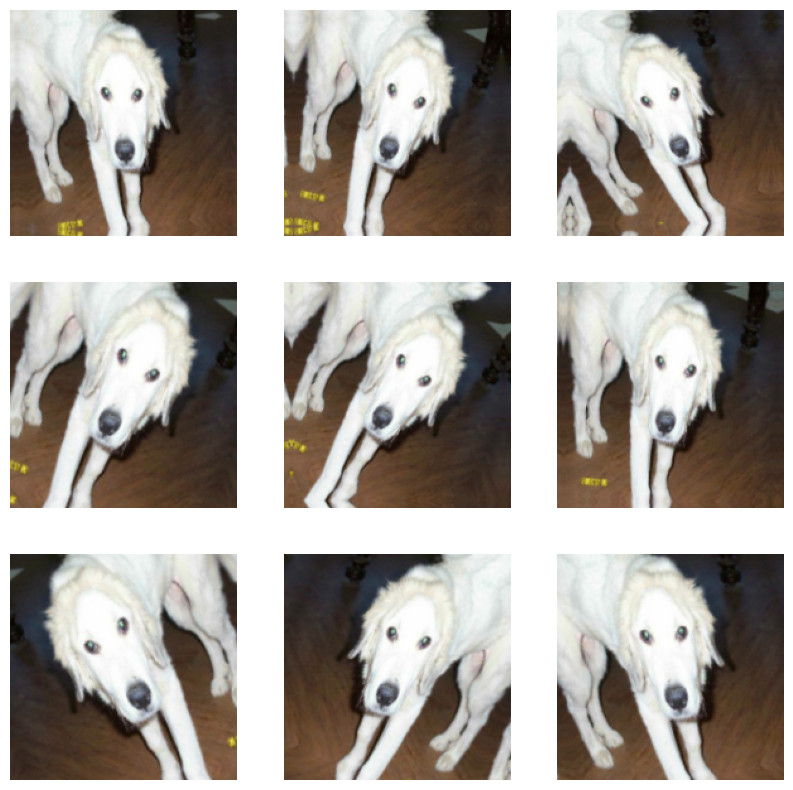

In [66]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [67]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [68]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
250/250 [==============================] - 17s 57ms/step - loss: 0.6878 - accuracy: 0.5321 - val_loss: 0.6785 - val_accuracy: 0.5820
Epoch 2/100
250/250 [==============================] - 14s 56ms/step - loss: 0.6644 - accuracy: 0.5943 - val_loss: 0.6482 - val_accuracy: 0.6360
Epoch 3/100
250/250 [==============================] - 14s 57ms/step - loss: 0.6357 - accuracy: 0.6334 - val_loss: 0.6412 - val_accuracy: 0.6530
Epoch 4/100
250/250 [==============================] - 14s 56ms/step - loss: 0.6142 - accuracy: 0.6658 - val_loss: 0.5808 - val_accuracy: 0.7050
Epoch 5/100
250/250 [==============================] - 15s 58ms/step - loss: 0.5791 - accuracy: 0.6930 - val_loss: 0.5567 - val_accuracy: 0.7120
Epoch 6/100
250/250 [==============================] - 14s 57ms/step - loss: 0.5444 - accuracy: 0.7255 - val_loss: 0.5559 - val_accuracy: 0.7150
Epoch 7/100
250/250 [==============================] - 14s 56ms/step - loss: 0.5159 - accuracy: 0.7486 - val_loss: 0.4509 - val_ac

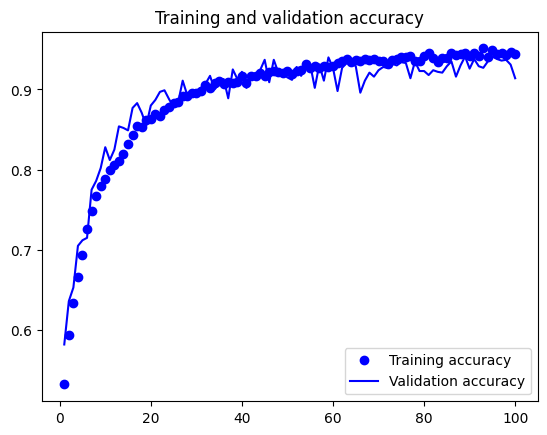

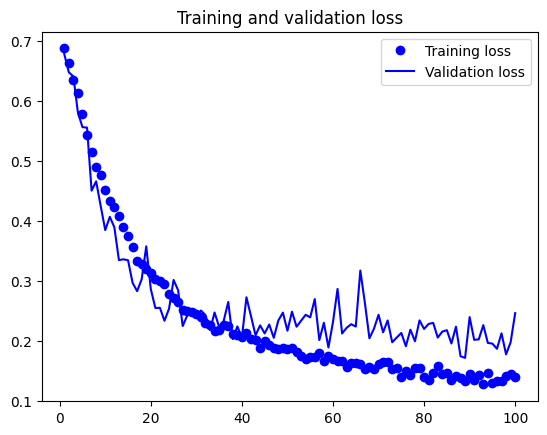

In [69]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [70]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 45ms/step - loss: 0.2402 - accuracy: 0.9130
Test accuracy: 0.913


In [72]:
conv_base = keras.applications.inception_v3.InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [73]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.inception_v3.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 27ms/step


In [74]:
train_features.shape

(8000, 4, 4, 2048)

In [75]:
inputs = keras.Input(shape=(4, 4, 2048))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
250/250 [==============================] - 3s 8ms/step - loss: 4.0169 - accuracy: 0.9615 - val_loss: 1.9271 - val_accuracy: 0.9800
Epoch 2/20
250/250 [==============================] - 1s 6ms/step - loss: 2.7026 - accuracy: 0.9774 - val_loss: 2.5689 - val_accuracy: 0.9760
Epoch 3/20
250/250 [==============================] - 1s 6ms/step - loss: 1.0381 - accuracy: 0.9890 - val_loss: 2.3702 - val_accuracy: 0.9810
Epoch 4/20
250/250 [==============================] - 1s 6ms/step - loss: 1.0073 - accuracy: 0.9870 - val_loss: 2.8940 - val_accuracy: 0.9760
Epoch 5/20
250/250 [==============================] - 2s 7ms/step - loss: 0.7866 - accuracy: 0.9891 - val_loss: 1.9171 - val_accuracy: 0.9870
Epoch 6/20
250/250 [==============================] - 2s 6ms/step - loss: 0.4430 - accuracy: 0.9929 - val_loss: 2.1420 - val_accuracy: 0.9820
Epoch 7/20
250/250 [==============================] - 2s 7ms/step - loss: 0.2632 - accuracy: 0.9952 - val_loss: 2.6112 - val_accuracy: 0.9790
Epoch 

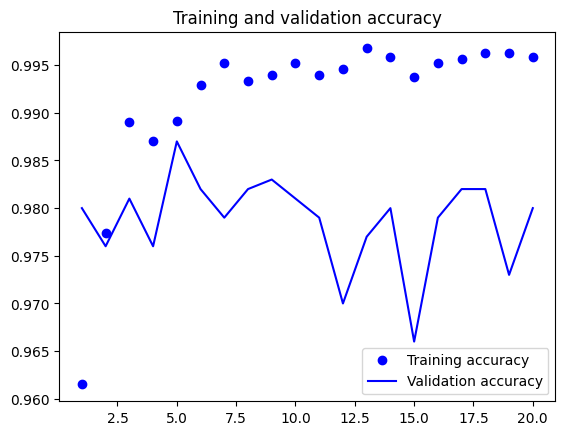

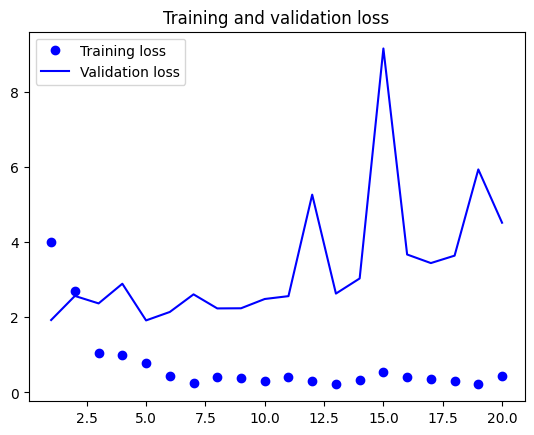

In [76]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [77]:
conv_base  = keras.applications.inception_v3.InceptionV3(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [78]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 188


In [79]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [80]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.inception_v3.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [81]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
250/250 [==============================] - 25s 74ms/step - loss: 6.5592 - accuracy: 0.9365 - val_loss: 3.4493 - val_accuracy: 0.9590
Epoch 2/50
250/250 [==============================] - 18s 69ms/step - loss: 3.6565 - accuracy: 0.9519 - val_loss: 1.3199 - val_accuracy: 0.9790
Epoch 3/50
250/250 [==============================] - 18s 72ms/step - loss: 1.8863 - accuracy: 0.9603 - val_loss: 0.9559 - val_accuracy: 0.9750
Epoch 4/50
250/250 [==============================] - 18s 69ms/step - loss: 1.2071 - accuracy: 0.9645 - val_loss: 0.4663 - val_accuracy: 0.9810
Epoch 5/50
250/250 [==============================] - 18s 69ms/step - loss: 0.5031 - accuracy: 0.9681 - val_loss: 0.3992 - val_accuracy: 0.9750
Epoch 6/50
250/250 [==============================] - 17s 69ms/step - loss: 0.2886 - accuracy: 0.9703 - val_loss: 0.1636 - val_accuracy: 0.9800
Epoch 7/50
250/250 [==============================] - 19s 73ms/step - loss: 0.2042 - accuracy: 0.9643 - val_loss: 0.1200 - val_accuracy:

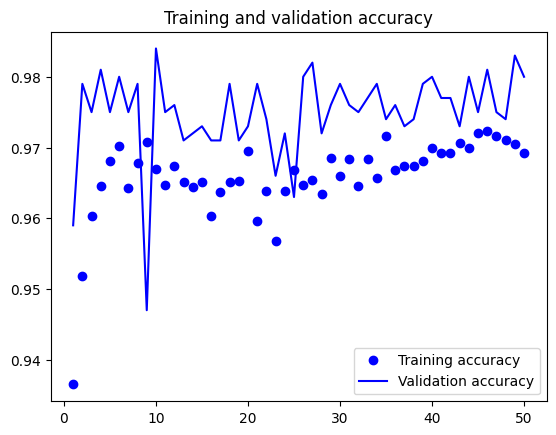

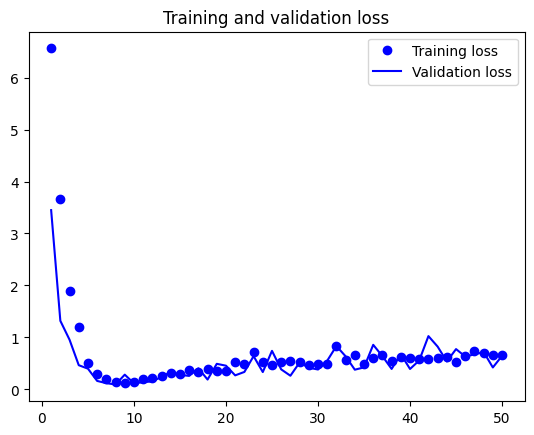

In [82]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [83]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 49ms/step - loss: 0.0781 - accuracy: 0.9830
Test accuracy: 0.983


In [84]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_772 (Conv2D)            (None, None, None,   864         ['input_16[0][0]']               
                                32)                                                               
                                                                                                  
 batch_normalization_752 (Batch  (None, None, None,   96         ['conv2d_772[0][0]']             
 Normalization)                 32)                                                    

In [85]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [86]:
from keras.optimizers import Adam
optimizer = Adam(lr=0.001)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
250/250 [==============================] - 24s 72ms/step - loss: 0.7674 - accuracy: 0.9716 - val_loss: 0.7029 - val_accuracy: 0.9770
Epoch 2/30
250/250 [==============================] - 17s 68ms/step - loss: 0.6762 - accuracy: 0.9732 - val_loss: 0.6020 - val_accuracy: 0.9760
Epoch 3/30
250/250 [==============================] - 17s 67ms/step - loss: 0.6350 - accuracy: 0.9734 - val_loss: 0.5794 - val_accuracy: 0.9790
Epoch 4/30
250/250 [==============================] - 16s 64ms/step - loss: 0.6143 - accuracy: 0.9743 - val_loss: 0.6449 - val_accuracy: 0.9830
Epoch 5/30
250/250 [==============================] - 16s 65ms/step - loss: 0.6881 - accuracy: 0.9736 - val_loss: 1.3279 - val_accuracy: 0.9700
Epoch 6/30
250/250 [==============================] - 16s 65ms/step - loss: 0.7982 - accuracy: 0.9704 - val_loss: 0.7650 - val_accuracy: 0.9770
Epoch 7/30
250/250 [==============================] - 16s 65ms/step - loss: 0.6385 - accuracy: 0.9741 - val_loss: 1.6508 - val_accuracy:

In [87]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 5s 90ms/step - loss: 0.4360 - accuracy: 0.9840
Test accuracy: 0.984
